# Fibroblast analysis - demo #2

In this notebook I perform primary analysis of liver fibroblast population using tools written in python. I am using single-cell publicly available data to find patterns and differences between fibroblast subsets.

### Importing packages

In [32]:
random.seed(12)
import os
import pickle
import random
import yaml

from frozendict import frozendict 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy.sparse as sp

import networkx as nx
import scanpy as sc
from pyscenic.export import add_scenic_metadata
from pyscenic.aucell import aucell
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons

### Load the data

In [2]:
BASE_FOLDER = "/NVME/projects/fibrosis_tf/intermediate/mouse"

EXP_MTX_QC_TPM_FNAME = os.path.join(BASE_FOLDER, "exp_mtx.qc.tpm.csv")
REGULONS_DAT_FNAME = os.path.join(BASE_FOLDER, 'regulons.dat')
YAML_DAT_FNAME = os.path.join(BASE_FOLDER, "mouse_{}.yaml")

# Load AnnData object
ANNDATA_FNAME = os.path.join(BASE_FOLDER, "mouse.h5ad")

In [ ]:
adata = sc.read_h5ad(ANNDATA_FNAME)

In [4]:
adata = adata[adata.obs['organ'] == 'ML'].copy()

In [5]:
# Preprocess data: keep only the most variable genes
adata.var_names = adata.var_names.str.replace(r"\.\d+$", "", regex=True)

In [6]:
adata.to_df().to_csv(EXP_MTX_QC_TPM_FNAME)

### Run pyscenic

In [7]:
os.system(
    f"pyscenic grn {EXP_MTX_QC_TPM_FNAME} {BASE_FOLDER}/mm_mgi_tfs.txt "
    f"-o {BASE_FOLDER}/mouse_adjacencies.tsv --num_workers 20"
)


2025-01-08 10:43:47,745 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-01-08 10:43:48,475 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/home/kgalat/conda3/envs/pyscenic/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42003 instead
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to 

preparing dask client
parsing input
creating dask graph
20 partitions
computing dask graph
not shutting down client, client was created externally
finished



2025-01-08 10:48:48,434 - pyscenic.cli.pyscenic - INFO - Writing results to file.


0

In [8]:
os.system(
    f"pyscenic ctx {BASE_FOLDER}/mouse_adjacencies.tsv "
    f"{BASE_FOLDER}/mm9-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather "
    f"{BASE_FOLDER}/mm9-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather "
    f"{BASE_FOLDER}/mm9-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather "
    f"--annotations_fname {BASE_FOLDER}/motifs-v9-nr.mgi-m0.001-o0.0.tbl "
    f"--expression_mtx_fname {EXP_MTX_QC_TPM_FNAME} "
    f"--output {BASE_FOLDER}/mouse.motifs.csv --num_workers 15"
)


2025-01-08 10:48:52,924 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-01-08 10:48:52,975 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-01-08 10:48:53,712 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-01-08 10:48:53,725 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2025-01-08 10:48:54,500 - pyscenic.utils - INFO - Creating modules.

2025-01-08 10:48:58,958 - pyscenic.cli.pyscenic - I

0

In [9]:
# Check if motifs file is empty
if os.stat(f"{BASE_FOLDER}/mouse.motifs.csv").st_size == 0:
    raise ValueError("No motifs found, stopping pipeline.")

# Generate regulons
motifs = load_motifs(f"{BASE_FOLDER}/mouse.motifs.csv")
motifs = motifs[(motifs[('Enrichment', 'NES')]>3)  & (motifs[('Enrichment','Annotation')].str.contains('directly annotated'))]
regulons = df2regulons(motifs)
regulons = [r.rename(r.transcription_factor) for r in regulons if len(r) >= 10]

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [10]:
# Save regulons
with open(REGULONS_DAT_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

### Run AUCell

In [11]:
# Compute AUCell matrix for all cells
exp_mtx = adata.to_df()
auc_mtx = aucell(exp_mtx, regulons, num_workers=20)

# Add SCENIC metadata
# add_scenic_metadata(adata, auc_mtx, regulons)

In [12]:
# Save YAML data
yaml_data = {
    r.name: [[gene, weight] for gene, weight in r.gene2weight.items()] for r in regulons
}
yaml_fname = YAML_DAT_FNAME.format("liver")
with open(yaml_fname, "w") as file:
    yaml.dump(yaml_data, file, default_flow_style=False)

/home/kgalat/conda3/envs/pyscenic/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  dot_ax.scatter(x, y, **kwds)


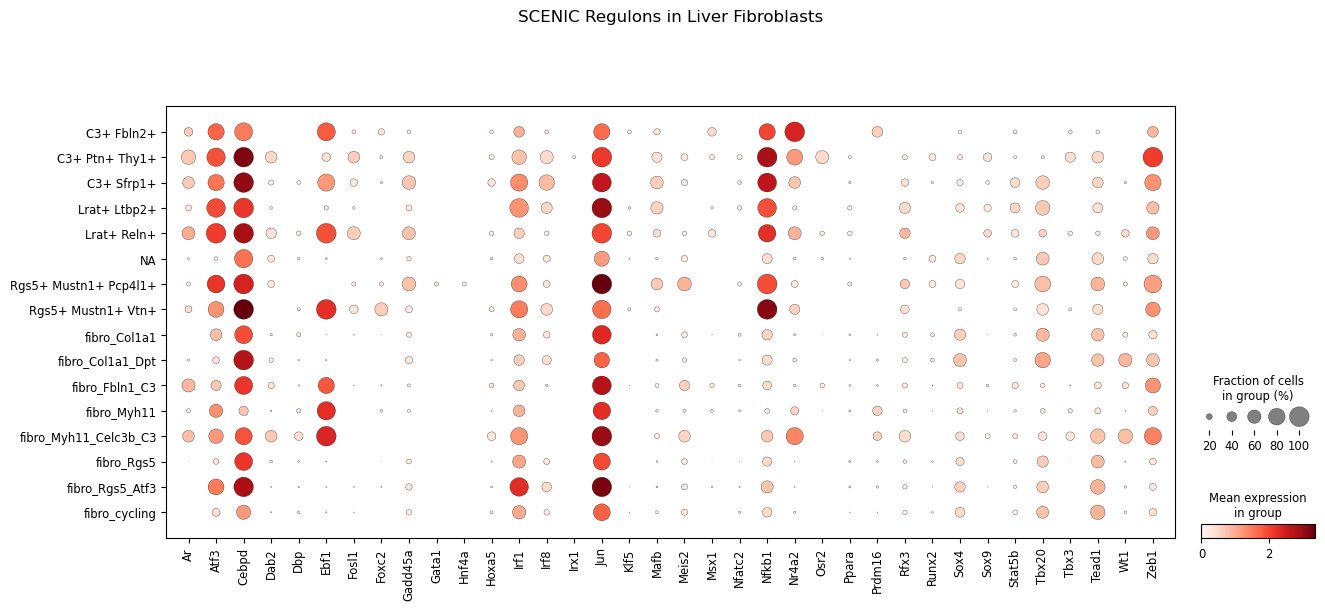

In [13]:
# Generate dotplots
sc.pl.dotplot(
    adata, [r.name for r in regulons], groupby="seurat_annotations",
    title=f"SCENIC Regulons in Liver Fibroblasts"
)

### Compare the most interesting clusters

In [14]:
def rank_genes_groups_to_df(adata, cell):
    
    dic = adata.uns['rank_genes_groups'] 
    
    df = pd.DataFrame({
        'names' : dic['names'][cell],
        'scores' : dic['scores'][cell],
        'pvals' : dic['pvals'][cell],
        'pvals_adj' : dic['pvals_adj'][cell],
        'logfoldchanges' : dic['logfoldchanges'][cell]
    })
    
    return df

In [15]:
def get_exp_proportion(
        adata, groupby, use_rep='X'):
    """get proportion of expressing cells from grouped sc data
    """
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
    elif use_rep == 'raw':
        x = adata.raw.X
        features = adata.raw.var_names.values
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        if sp.issparse(x):
            summarised[i] = np.sum(x[k_grp,:]>0,axis=0)/x[k_grp,:].shape[0]
        else:
            print('X is not sparce')
            
            ################# added here #################
            summarised[i] = np.sum(x[k_grp,:]>0,axis=0)/x[k_grp,:].shape[0]
            ##############################################
            
    return pd.DataFrame(summarised.T, columns=groups, index=features)

In [16]:
adata.obs['cell_state_2'] = adata.obs['seurat_annotations'].astype('str')

In [17]:
# subset cell types of interest
target_celltype = 'Rgs5+ Mustn1+ Vtn+'
celltype_group = ['Rgs5+ Mustn1+ Vtn+','fibro_cycling']

adata_rna = adata[adata.obs['cell_state_2'].isin(celltype_group)]

In [18]:
adata_rna.obs['cell_state_2'].value_counts()

fibro_cycling         87
Rgs5+ Mustn1+ Vtn+    12
Name: cell_state_2, dtype: int64

In [19]:
# DEG calculation
sc.tl.rank_genes_groups(adata_rna, 'cell_state_2', 
                        groups=[target_celltype], reference='rest', 
                        method='wilcoxon')

degs_df = rank_genes_groups_to_df(adata_rna, target_celltype)

/home/kgalat/conda3/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [20]:
# select degs (for TF)
pval_adj_thresh = 0.05
degs_df = degs_df[degs_df['pvals_adj'] < pval_adj_thresh]

rna_degs_UP = list(degs_df[degs_df['logfoldchanges'] > 0]['names'])
rna_degs_DOWN = list(degs_df[degs_df['logfoldchanges'] < 0]['names'])

In [21]:
len(rna_degs_UP)

172

In [22]:
len(rna_degs_DOWN)

121

In [23]:
# select genes which has larger proportion in a group of interest 
# here 10%
exp_prop = get_exp_proportion(adata_rna, groupby='cell_state_2')
exp_genes = exp_prop.index[exp_prop[target_celltype] > 0.1]
len(exp_genes)

X is not sparce
X is not sparce


728

In [24]:
# with open(YAML_DAT_FNAME.format("liver"), 'r') as f:
#     regulons = yaml.safe_load(f)

In [67]:
key_TF_TG = {}

for regulon in regulons:
    tf = regulon.transcription_factor 
    tg_weights = regulon.gene2weight  
    
    if tf in rna_degs_UP and tf in exp_genes:
        key_tgs = [tg for tg in tg_weights.keys() if tg in rna_degs_UP]
        
        if key_tgs:
            key_TF_TG[tf] = key_tgs

In [69]:
# prepare dataframe of TF and TGs and save
tftg_df = pd.DataFrame({'TF':[],'TF_logFC':[],'TargetGene':[],'TargetGene_logFC':[]})
for k,v in key_TF_TG.items():
    # get logFC for TF
    tf_logfc = degs_df.set_index('names').loc[k,'logfoldchanges']
    for vv in v:
        # get logFC for TG
        tg_logfc = degs_df.set_index('names').loc[vv,'logfoldchanges']

    df = pd.DataFrame({'TF':[k],'TF_logFC':[tf_logfc],'TargetGene':[vv],'TargetGene_logFC':[tg_logfc],'ATAC_interaction':['No']})
        
    tftg_df = pd.concat([tftg_df,df],axis=0)
print(len(tftg_df))

3


In [70]:
tftg_df

,TF,TF_logFC,TargetGene,TargetGene_logFC,ATAC_interaction
0,Cebpd,3.580226,Nfkb1,5.233487,No
0,Ebf1,7.583123,Aspn,30.897133,No
0,Nfkb1,5.233487,Adarb1,5.291045,No


In [71]:
# set a threshold of logFC (for both TF and TG) for plotting
FC_thresh_for_plot = 0.5

df = tftg_df[(tftg_df['TF_logFC'] > FC_thresh_for_plot)&(tftg_df['TargetGene_logFC'] > FC_thresh_for_plot)]

# make TF:TG dictionary for plotting
key_TF_TG_plot = {}
for tf in set(df['TF']):
    key_TF_TG_plot[tf] = list(df[df['TF']==tf]['TargetGene'])

len(df)

3

In [48]:
# definition of function
def generate_edges(graph):
    edges = []
  
    # for each node in graph
    for node in graph:
          
        # for each neighbour node of a single node
        for neighbour in graph[node]:
              
            # if edge exists then append
            edges.append((node, neighbour))
    return edges

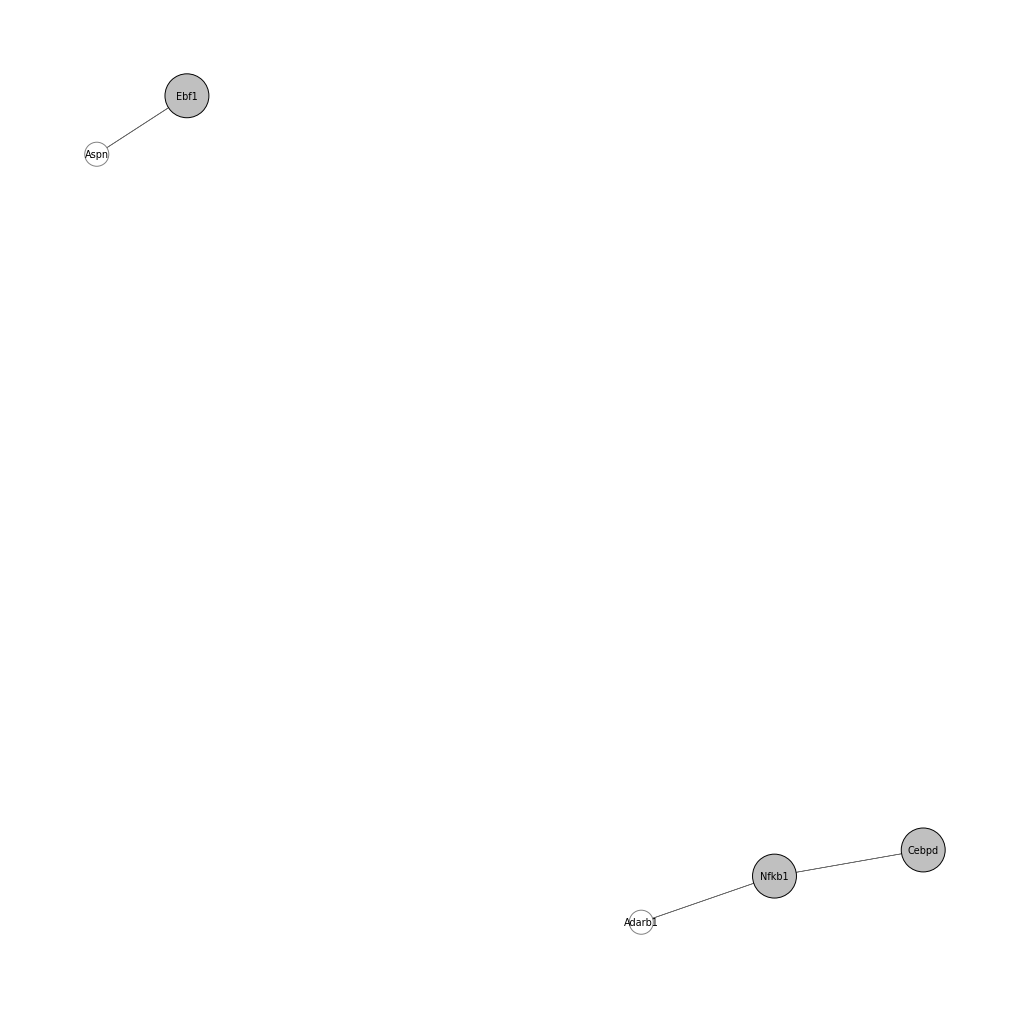

In [83]:
G = nx.Graph()
G.add_edges_from(generate_edges(key_TF_TG_plot))

col_map = {}
size_map = {}
edgecolors_map = {}
for k in key_TF_TG_plot.keys():
    col_map[k]='silver'
    size_map[k]=1000
    edgecolors_map[k]='black'  # '#FF000000'
    
colors = [col_map.get(node, 'white') for node in G.nodes()]

sizes = [size_map.get(node, 300) for node in G.nodes()]

edgecolors= [edgecolors_map.get(node, 'grey') for node in G.nodes()]
## edges between nodes
edges = G.edges(data=True)
edge_color_list = []
edge_width_list = []
for x in edges:
    if x[0] in key_TF_TG_plot.keys():
        edge_color_list.append('dimgrey')
        edge_width_list.append(0.5)
    elif x[1] in key_TF_TG_plot.keys():
        edge_color_list.append('dimgrey')
        edge_width_list.append(0.5)

pos = nx.spring_layout(G,k=0.25,scale=2)
#https://networkx.org/documentation/latest/reference/generated/networkx.drawing.layout.spring_layout.html

plt.figure(figsize = (10,10))
nx.draw(G, pos, node_color = colors, node_size = sizes, edgecolors=edgecolors,
       with_labels = True, width=0.4, font_size=7, linewidths=0.7)
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_labels_and_colors.html
nx.draw_networkx_edges(G, pos, edge_color=edge_color_list, width=edge_width_list)
plt.savefig(f'{target_celltype}_GRN_UP_UP.pdf')
plt.show()

### DOWN

In [81]:
key_TF_TG = {}

for regulon in regulons:
    tf = regulon.transcription_factor 
    tg_weights = regulon.gene2weight  
    
    if tf in rna_degs_UP and tf in exp_genes:
        key_tgs = [tg for tg in tg_weights.keys() if tg in rna_degs_DOWN]
        
        if key_tgs:
            key_TF_TG[tf] = key_tgs

In [84]:
# prepare dataframe of TF and TGs and save
tftg_df = pd.DataFrame({'TF':[],'TF_logFC':[],'TargetGene':[],'TargetGene_logFC':[]})
for k,v in key_TF_TG.items():
    # get logFC for TF
    tf_logfc = degs_df.set_index('names').loc[k,'logfoldchanges']
    for vv in v:
        # get logFC for TG
        tg_logfc = degs_df.set_index('names').loc[vv,'logfoldchanges']

    df = pd.DataFrame({'TF':[k],'TF_logFC':[tf_logfc],'TargetGene':[vv],'TargetGene_logFC':[tg_logfc],'ATAC_interaction':['No']})
        
    tftg_df = pd.concat([tftg_df,df],axis=0)
print(len(tftg_df))

2


In [86]:
# set a threshold of logFC (for both TF and TG) for plotting
FC_thresh_for_plot = 0.5

df = tftg_df[(tftg_df['TF_logFC'] > FC_thresh_for_plot)&(tftg_df['TargetGene_logFC'] < FC_thresh_for_plot)]

# make TF:TG dictionary for plotting
key_TF_TG_plot = {}
for tf in set(df['TF']):
    key_TF_TG_plot[tf] = list(df[df['TF']==tf]['TargetGene'])

len(df)

2

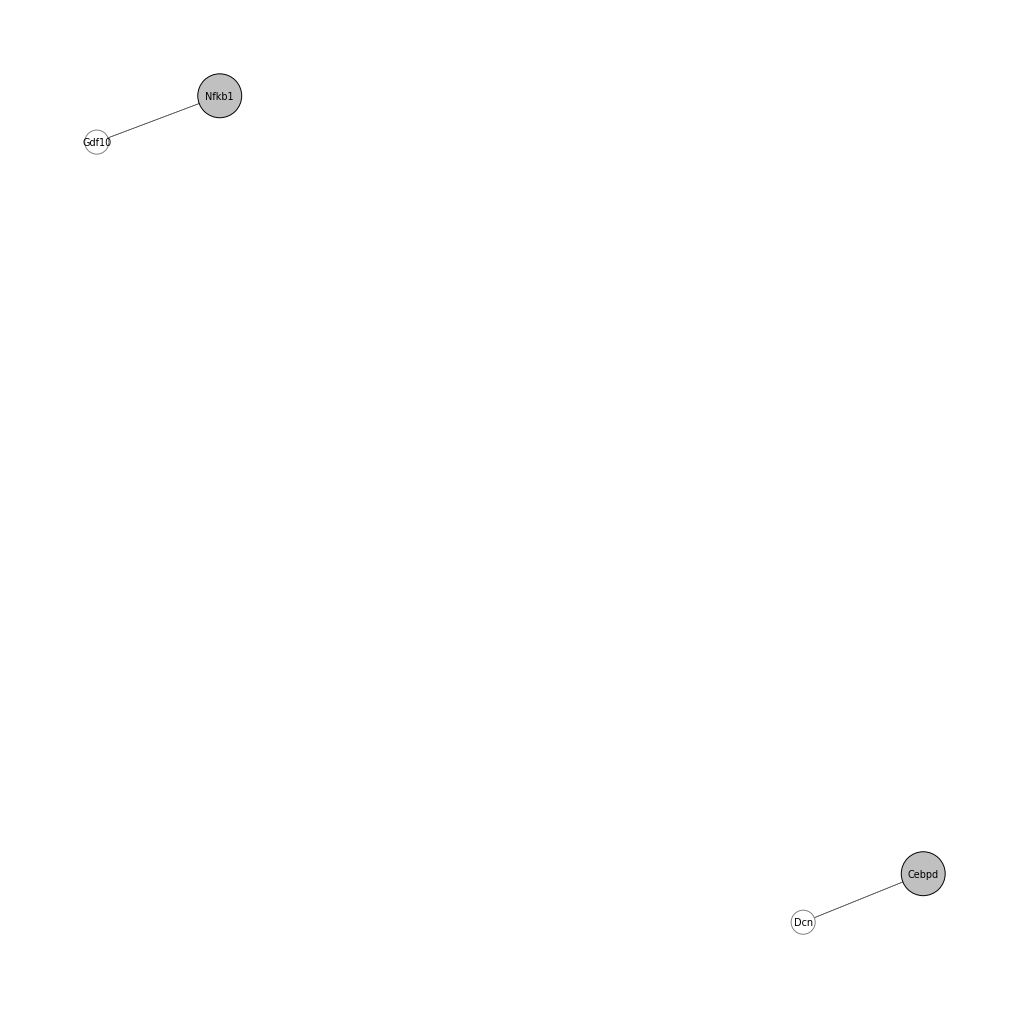

In [88]:
G = nx.Graph()
G.add_edges_from(generate_edges(key_TF_TG_plot))

col_map = {}
size_map = {}
edgecolors_map = {}
for k in key_TF_TG_plot.keys():
    col_map[k]='silver'
    size_map[k]=1000
    edgecolors_map[k]='black'  # '#FF000000'
    
colors = [col_map.get(node, 'white') for node in G.nodes()]

sizes = [size_map.get(node, 300) for node in G.nodes()]

edgecolors= [edgecolors_map.get(node, 'grey') for node in G.nodes()]
## edges between nodes
edges = G.edges(data=True)
edge_color_list = []
edge_width_list = []
for x in edges:
    if x[0] in key_TF_TG_plot.keys():
        edge_color_list.append('dimgrey')
        edge_width_list.append(0.5)
    elif x[1] in key_TF_TG_plot.keys():
        edge_color_list.append('dimgrey')
        edge_width_list.append(0.5)

pos = nx.spring_layout(G,k=0.25,scale=2)
#https://networkx.org/documentation/latest/reference/generated/networkx.drawing.layout.spring_layout.html

plt.figure(figsize = (10,10))
nx.draw(G, pos, node_color = colors, node_size = sizes, edgecolors=edgecolors,
       with_labels = True, width=0.4, font_size=7, linewidths=0.7)
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_labels_and_colors.html
nx.draw_networkx_edges(G, pos, edge_color=edge_color_list, width=edge_width_list)
plt.savefig(f'{target_celltype}_GRN_UP_DOWN.pdf')
plt.show()